<a href="https://colab.research.google.com/github/mikedcurry/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/Curry_LS_DS_113__Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [0]:
import random
#dir(random)  # Reminding ourselves what we can do here

In [0]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [0]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=False, time_on_site=180.18849314523848, mobile=False), User(purchased=True, time_on_site=135.67700482149365, mobile=False), User(purchased=True, time_on_site=159.88535379510446, mobile=True), User(purchased=True, time_on_site=257.7835981679507, mobile=True), User(purchased=False, time_on_site=86.99445445027507, mobile=False), User(purchased=False, time_on_site=173.67358829592212, mobile=True), User(purchased=True, time_on_site=44.968058188901246, mobile=True), User(purchased=False, time_on_site=30.15219480121866, mobile=True), User(purchased=False, time_on_site=460.0007745853941, mobile=False), User(purchased=False, time_on_site=122.22911474525455, mobile=True)]


In [0]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,180.188493,False
1,True,135.677005,False
2,True,159.885354,True
3,True,257.783598,True
4,False,86.994454,False


In [0]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.395806383057993,5.457727420381445,6.012980358659168,6.370819673044487,6.526220869482321,6.618506115477453,6.744300972093091,6.937814523764514,7.022230321283178,7.738183255456649,...,570.7205763776294,572.579212329361,573.071762294419,577.5607756708825,578.0265919014007,578.8349054472059,584.0914381586123,586.960469433746,588.7975083689481,599.8083961016524
purchased,,,,,,,,,,,,,,,,,,,,,
False,1,1,1,1,1,1,1,1,1,1,...,0,1,1,1,1,0,0,0,1,1
True,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,1,1,0,0


In [0]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(4.801, 124.278]","(124.278, 243.161]","(243.161, 362.043]","(362.043, 480.926]","(480.926, 599.808]"
purchased,,,,,
False,240,233,105,29,28
True,96,131,102,20,16


In [0]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(4.801, 124.278]","(124.278, 243.161]","(243.161, 362.043]","(362.043, 480.926]","(480.926, 599.808]"
purchased,,,,,
False,0.714286,0.64011,0.507246,0.591837,0.636364
True,0.285714,0.35989,0.492754,0.408163,0.363636


In [0]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.672,0.622667
True,0.328,0.377333


In [0]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [0]:
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself

In [43]:
#loading the csv
import pandas as pd
url = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-1-Sprint-1-Dealing-With-Data/master/module3-databackedassertions/persons.csv'

persons = pd.read_csv(url)
persons.head()

,Unnamed: 0,age,weight,exercise_time
0,0,44,118,192
1,1,41,161,35
2,2,46,128,220
3,3,39,216,57
4,4,28,116,182


**Pre-Anaylsis Notes:**
Before diving much more deeply into the data, I think it makes sense to come back and take a moment to examine my own biasis and reflect on what can actually concluded from what we're given. 

*Things that I expect from an intuitive perspecitve: *

1.   Longer excercise time will be negatively corrilated to weight.
2.   Age will be negatively corelated to excercise time. I'll have to look out for this as a confounding factor.

 I don't think the data here supports a causal relationship between weight and excercise time. If a person is a bit overweight they probably wont be able to excercise as long as a person who is a bit more trim. 

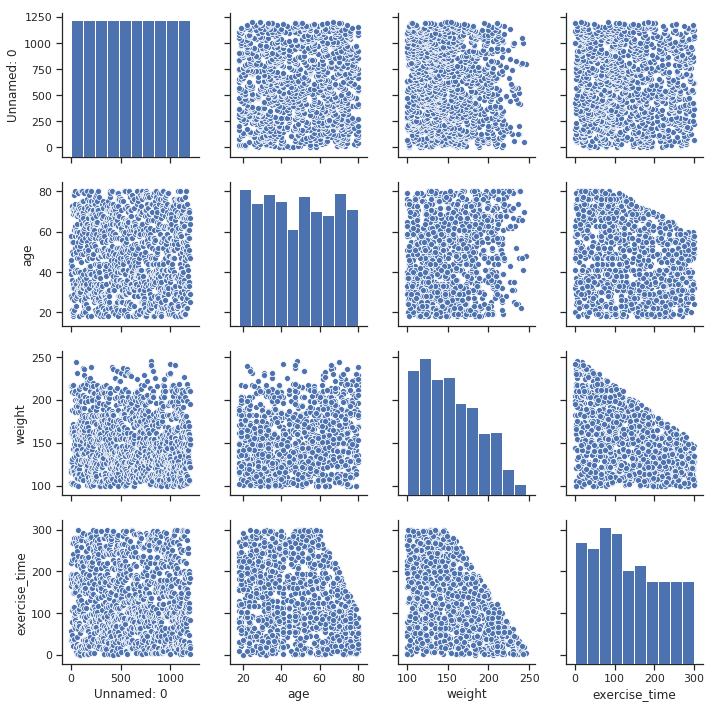

In [40]:
import seaborn as sns

sns.set(style="ticks", color_codes=True)

g = sns.pairplot(persons)

hmm... looks a little bit cooked, but okay.

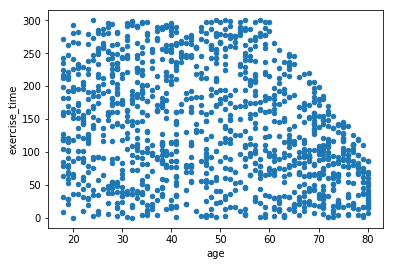

In [29]:
#exercise time vs age

persons.plot.scatter('age', 'exercise_time');

**Note:** From the above scatter plot it is apparent that past 60, people excercise for progressively less durations.

It appears that this is a "confounding" factor.


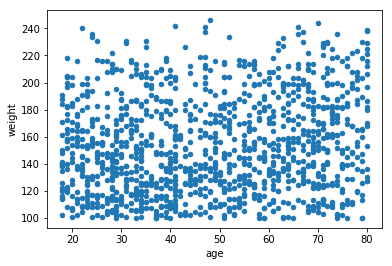

In [34]:
#exercise age vs weight

persons.plot.scatter('age', 'weight');

# I think this rules out a connection between weight and age... so I guess that 
# means that even though older people excercise for shorter times, they are not 
# heavier as a result?

In [44]:
!pip install pandas==0.23.4

     |████████████████████████████████| 8.9MB 1.8MB/s 
ERROR: google-colab 1.0.0 has requirement pandas~=0.24.0, but you'll have pandas 0.23.4 which is incompatible.
  Found existing installation: pandas 0.24.2
    Uninstalling pandas-0.24.2:
      Successfully uninstalled pandas-0.24.2


In [0]:
age_bins = pd.cut(persons['age'], 5)
weight_bins = pd.cut(persons['weight'], 5)
duration_bins = pd.cut(persons['exercise_time'], 5)

In [10]:
pd.crosstab(weight_bins, age_bins, normalize='columns')

#this didnt' help me, but it was fun messing with crosstab
#probably this function is best with booleans.. I guess I could convert something 
#but I'm moving on

age,"(17.938, 30.4]","(30.4, 42.8]","(42.8, 55.2]","(55.2, 67.6]","(67.6, 80.0]"
weight,,,,,
"(99.854, 129.2]",0.312500,0.411067,0.349776,0.238739,0.243902
"(129.2, 158.4]",0.335938,0.245059,0.278027,0.319820,0.219512
"(158.4, 187.6]",0.191406,0.193676,0.219731,0.202703,0.268293
"(187.6, 216.8]",0.132812,0.122530,0.116592,0.198198,0.178862
"(216.8, 246.0]",0.027344,0.027668,0.035874,0.040541,0.089431


In [37]:
ct = pd.crosstab(weight_bins, duration_bins, normalize='columns')

ct

exercise_time,"(-0.3, 60.0]","(60.0, 120.0]","(120.0, 180.0]","(180.0, 240.0]","(240.0, 300.0]"
weight,,,,,
"(99.854, 129.2]",0.190647,0.205696,0.318386,0.411458,0.560209
"(129.2, 158.4]",0.158273,0.240506,0.300448,0.385417,0.387435
"(158.4, 187.6]",0.219424,0.294304,0.251121,0.197917,0.052356
"(187.6, 216.8]",0.273381,0.231013,0.130045,0.005208,0.000000
"(216.8, 246.0]",0.158273,0.028481,0.000000,0.000000,0.000000


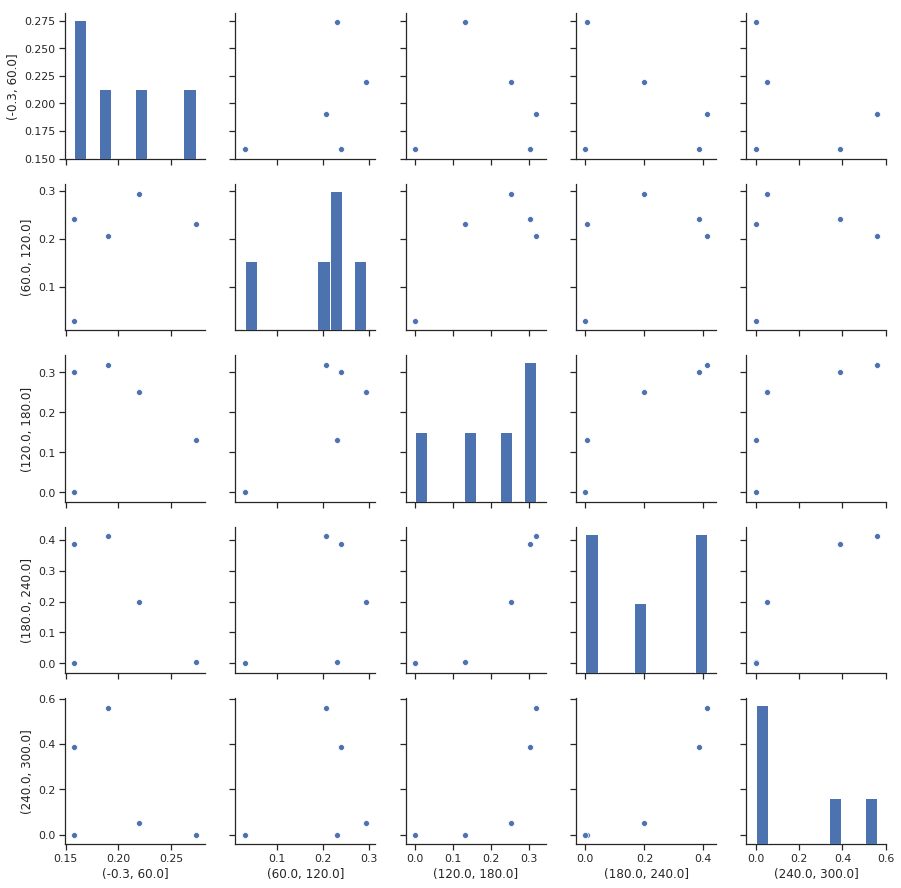

In [41]:
import seaborn as sns

sns.set(style="ticks", color_codes=True)

g = sns.pairplot(ct)

In [0]:
#going to attempt the use of a pivot table

pt = pd.pivot_table(persons, values='', index=)
print(pt)

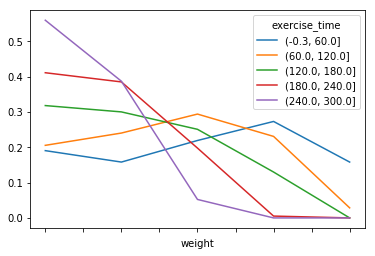

In [22]:
ct.plot();

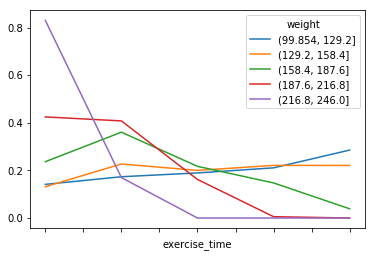

In [23]:
ct2 = pd.crosstab(duration_bins, weight_bins, normalize='columns')
ct2.plot();

As strong conclusion that can be reached here is that people in the heavier catagory (purple) exercise less. 


```
# This is formatted as code
```



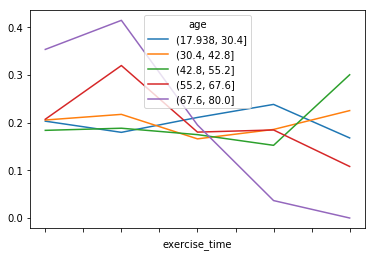

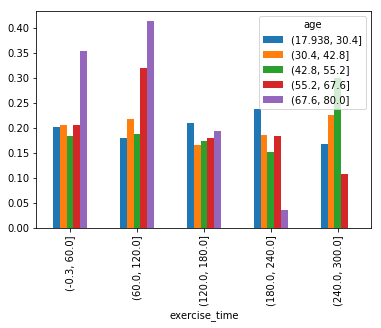

In [26]:
ct3 = pd.crosstab(duration_bins, age_bins, normalize='columns')
ct3.plot();
ct3.plot(kind='bar');


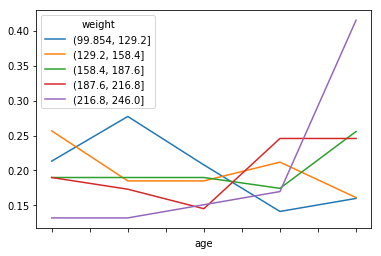

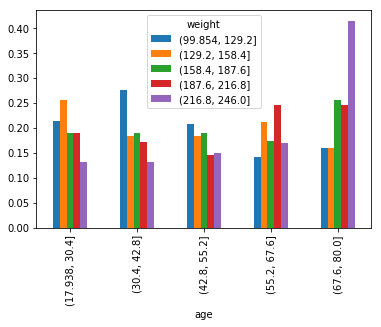

In [38]:
ct4 = pd.crosstab(age_bins, weight_bins, normalize='columns')
ct4.plot();
ct4.plot(kind='bar');

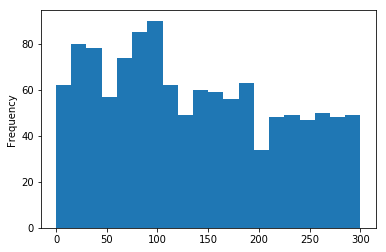

In [31]:
persons['exercise_time'].plot.hist(bins=20);

In [0]:
df2 = persons[(persons['age']>= 70) & (persons['age'] <= 80)]

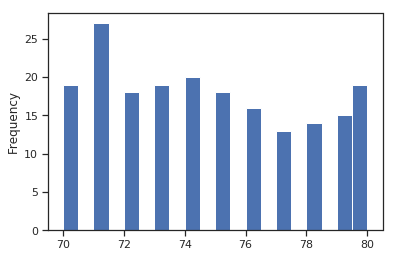

In [66]:
df2['age'].plot.hist(bins=20);

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


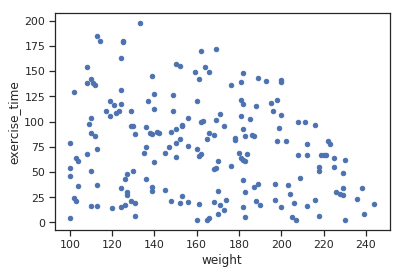

In [67]:
df2.plot.scatter('weight', 'exercise_time');

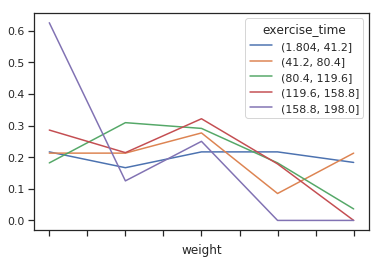

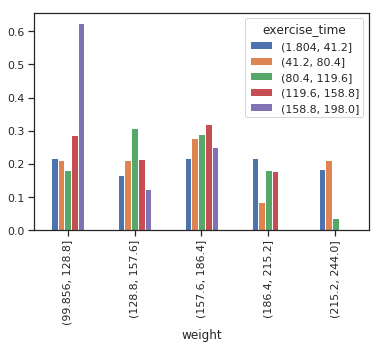

In [68]:
age_bins2 = pd.cut(df2['age'], 5)
weight_bins2 = pd.cut(df2['weight'], 5)
duration_bins2 = pd.cut(df2['exercise_time'], 5)

ct5 = pd.crosstab(weight_bins2, duration_bins2, normalize='columns')
ct5.plot();
ct5.plot(kind='bar');

In [0]:
df3 = persons[(persons['age']>= 17) & (persons['age'] <= 21)]

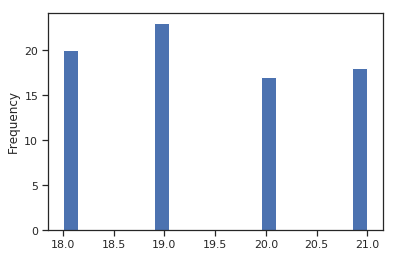

In [75]:
df3['age'].plot.hist(bins=20);

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


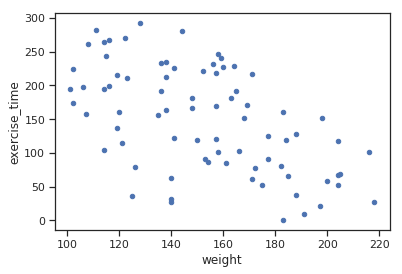

In [76]:
df3.plot.scatter('weight', 'exercise_time');

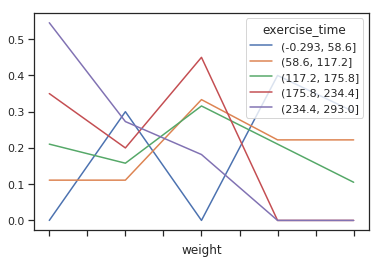

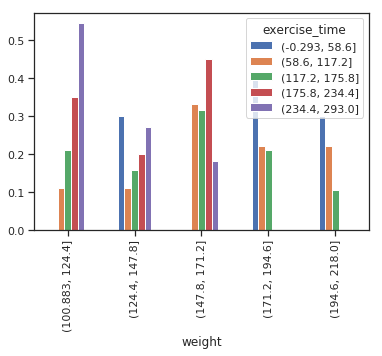

In [77]:
age_bins3 = pd.cut(df3['age'], 5)
weight_bins3 = pd.cut(df3['weight'], 5)
duration_bins3 = pd.cut(df3['exercise_time'], 5)

ct5 = pd.crosstab(weight_bins3, duration_bins3, normalize='columns')
ct5.plot();
ct5.plot(kind='bar');

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data? 
2.  What are the relationships between the variables?
3.  Which relationships are "real", and which spurious?


Okay, so the basic relationship starts to break down at the extremes of age, both young and old. So age is a confounder in those instances. Otherwise the relationship remains pretty solid: the greater the weight the less excercise time.  In other words there is a negative corrilation between weight and exercise, except for when your are very young or very old. Also, the greater the age the less exercise time. There was some question as to whether when you get older, since you are more likely to exercise less, and this is turn effects your weight. The relationship does appear to break down in the range of 70-80 years old. 

I'm not sure we can make any conclusion on which causes which: weight vs excercise time. If you weigh more, presumably it is harder to excercise for longer times. Likewise, if you excercise less you are likely to weigh more. I don't think it matters which is dependent or indendent. 



## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)